In this notebook, we represent the flow field by a limited collection of point vortices and seek to estimate their positions and strengths from pressure observations collected on the surface of a flat plate. The truth pressure observations are obtained from a high-fidelity simulations for the flow over an impulsively started flat plate at $20$ degrees of angle of attack at Reynolds number $Re = 500$. 

More details on the numerical experiment can be found in Le Provost, M., & Eldredge, J. D. (2021). Ensemble Kalman filter for vortex models of disturbed aerodynamic flows. Physical Review Fluids, 6(5), 050506.

The objective of this notebook is to compare the stochastic ensemble Kalman filter with the localized stochastic ensemble Kalman filter for this experiment. 

In [3]:
# Load libraries
using Revise
using TransportBasedInference
using LocalizedVortex
using PotentialFlow
import PotentialFlow.Plates: Plate
using Random
using ProgressMeter
using LinearAlgebra
using Statistics
using JLD
using Interpolations

In [4]:
# Load plotting libraries
using Plots
default(fontfamily = "Computer Modern",
        tickfont = font("Computer Modern", 9), 
        titlefont = font("Computer Modern", 14), 
        guidefont = font("Computer Modern", 12),
        grid = false)
pyplot()
using LaTeXStrings
using ColorSchemes

In [5]:
# Define colors
ccfd = colorant"navy blue"
cenkf = colorant"teal"
clocenkf = colorant"orangered2"
cgust = colorant"limegreen"
ctmap = colorant"purple"

Load truth pressure observations from high fidelity numerical simulations at $Re = 500$.

In [10]:
pwd()

"/Users/mathieu/Documents/LocalizedVortex.jl/notebooks"

In [11]:
thist, Fn, data, X̃, Δt, xg, yg = load("/Users/mathieu/Documents/VortexModels/CFD_generation/Results/flat_plate_convective_2gusts_06.jld",
                              "thist","Fn","pressure", "Xtilde", "dt", "xg", "yg");
Δs = mean(X̃[2:end]-X̃[1:end-1]);
T = range(thist[50], stop = thist[end], length = 100)
s = X̃[1]:Δs:X̃[end]

# Define space and time interpolated surface pressure field
pressure_data = CubicSplineInterpolation((s, T), reverse(hcat(data[50:50:end]...), dims = 1), 
                                          extrapolation_bc =  Line());

In [12]:
config = let N = 512, L = 1.0, ċ = 1.0,
             α = π/9, δ = 5e-3, Δt = 1e-2, 
             tesp = 0.0,
             ϵX = 1e-5, ϵΓ = 1e-5, ϵLESP = 5e-5,
             β = 1.0,
             ϵY = 1e-5
    VortexParams(N, L, ċ, α, δ, Δt, true, tesp, ϵX, ϵΓ, ϵLESP, β, ϵY)
end



0.0:0.01:5.0

x-t diagram of the pressure field along the airfoil 

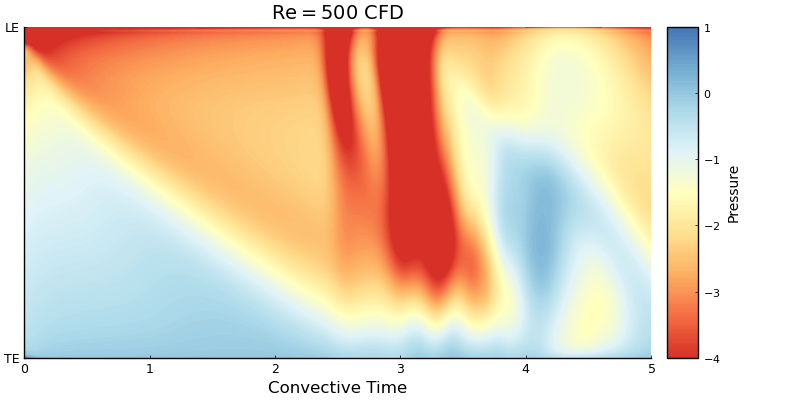

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
findfont: Font family ['Computer Modern'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Computer Modern'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Computer Modern'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Computer Modern'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Computer Modern'] not found. Falling back to DejaVu Sans.


In [13]:
sch = ColorSchemes.RdYlBu_9.colors
let s = [-0.5config.L*cos(θ) for θ in range(0.0, stop = π, length = config.N)][pressure_taps],
    #model_pressures = hcat((measure_state(mean(states[i+1]), t, config, pressure_taps) for (i,t) in enumerate(T))...),
    cfd_pressures = 2hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)
    plt = plot(size = (800, 400))
    contourf!(T, s, cfd_pressures, title = ["\$\\mathrm{Re} = 500\$ CFD" "EnKF Mean"],
        levels = range(-4.0, stop = 1, length = 161), clims = (-4, 1), color = cgrad(sch), xlabel = "Convective Time",
        #levels = linspace(-2, 2, 151), clims = (-2, 0.5), color = cgrad(reverse(colormap(:rainbow))), xlabel = ["Convective Time"],
        yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = sch[1],colorbar_title="Pressure")
        #yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap(:rainbow)[end], colorbar_title="Pressure")
#     contour!(T, s, cfd_pressures,levels=0.0:0.0, color = PlotUtils.get_colorscheme(:grays)[1])
end

## Model Formulation

Define the parameters of the numerical simulation of the flow field flat plate that is translating at a fixed angle of attack and velocity, represented as a collection of point vortices. We also use a constant blob radius on all of our vortex elements

In [14]:
config = let N = 512, L = 1.0, ċ = 1.0,
             α = π/9, δ = 9e-3, Δt = 1e-2, 
             tesp = 0.0,
             ϵX = 1e-5, ϵΓ = 2e-5, ϵLESP = 8.5e-4, 
             β = 1.028,
             ϵY = 1e-4

    VortexParams(N, L, ċ, α, δ, Δt, true, tesp, ϵX, ϵΓ, ϵLESP, β, ϵY)
end

idxp = 10:10:config.N-10

tf = 5.0
pressure_taps = 10:10:config.N-10
T = 0:config.Δt:tf

# Number of ensemble members
Ne = 50
# At initial time, the state is only compoised of the estimate for the LESPc.
Nx = 1
# Ny is the number of pressure observations used for the data assimilation.
Ny = size(idxp,1)

tspan = (0.0, 5.0)
ϵy = AdditiveInflation(zeros(Ny), config.ϵY)

enkf = StochEnKF(filter_state!, ϵy, config.Δt, config.Δt; isfiltered=true)

X0 = zeros(Ny+Nx, Ne)
m0 = 0.5
C0 = 0.05^2

X0[Ny+1,:] = m0 .+ sqrt(C0)*exactn(Ne);

Perform data assimilation with the stochastic ensemble Kalman filter (sEnKF). We use the classical implementation of the sEnKF found in many references, including the book by Asch, Bocquet, and Nodet, (2016), "Data assimilation: methods, algorithms, and applications." *Society for Industrial and Applied Mathematics*.

In [15]:
Xf, Xa = vortexassim(enkf, deepcopy(X0), tspan,  config, idxp, pressure_data);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


We perform data assimilation with the localized stochastic ensemble Kalman filter (localized sEnKF). We use two cut-off length scales: $L_{xy}$ for the cross-covariance matrix $\Sigma_{X, Y}$ and $L_{yy}$ for the covariance matrix $\Sigma_Y$. 

The regularization of the Kalman gain is performed as follows:

We use the Gaspari-Cohn function $G_{g}: \mathbb{R} \to \mathbb{R}$ with support $[-2, 2]$. 

We define the distance matrix between the state and observation variables $\mathcal{d}_{\boldsymbol{X}, \boldsymbol{Y}} \in \mathbb{R}^{N_x \times N_y}$, where $N_x, N_y$ is the dimension of the state space, observation space, respectively. For the $\mathsf{J}$th vortex element and the $k$th pressure sensor, the entries of indices $(3 \mathsf{J} - 2, k) , (3 \mathsf{J} - 1, k),  (3 \mathsf{J}, k)$  are equal to the distance (in Euclidian norm) between the $\mathsf{J}$ vortex element and the $k$th pressure sensor.

We define the distance matrix between the observation variables $\mathcal{d}_{\boldsymbol{Y}} \in \mathbb{R}^{N_y \times N_y}$ that holds the distance between the different pressure sensors. 

We regularize the cross-covariance matrix $\Sigma_{\boldsymbol{X}, \boldsymbol{Y}}$ by multiplying its entries element-wise by smoothed distance matrix $\tilde{\mathcal{d}}_{\boldsymbol{X}, \boldsymbol{Y}} = G_{g}\left(\frac{1}{L_{xy}}\mathcal{d}_{\boldsymbol{X}, \boldsymbol{Y}}\right)$: 

\begin{equation}
\tilde{\Sigma}_{\boldsymbol{X}, \boldsymbol{Y}} = \Sigma_{\boldsymbol{X}, \boldsymbol{Y}} \otimes \tilde{\mathcal{d}}_{\boldsymbol{X}, \boldsymbol{Y}}
\end{equation}

We regularize the covariance matrix $\Sigma_{\boldsymbol{Y}}$ by multiplying its entries element-wise by smoothed distance matrix $\tilde{\mathcal{d}}_{\boldsymbol{Y}} = G_{g}\left(\frac{1}{L_{yy}}\mathcal{d}_{\boldsymbol{Y}}\right)$: 

\begin{equation}
\tilde{\Sigma}_{\boldsymbol{Y}} = \Sigma_{\boldsymbol{Y}} \otimes \tilde{\mathcal{d}}_{\boldsymbol{Y}}
\end{equation}


The regularized Kalman gain is given by: 

\begin{equation}
\tilde{K} = \tilde{\Sigma}_{\boldsymbol{X}, \boldsymbol{Y}} {\tilde{\Sigma}_{\boldsymbol{Y}}}^{-1}
\end{equation}


In [16]:
Lxy = 1.0
Lyy = 0.6

0.6

In [17]:
Xf_loc, Xa_loc = localized_vortexassim(enkf, Lxy, Lyy, deepcopy(X0), tspan,  config, idxp, pressure_data);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


Comparison of the normal force estimate obtained by the sEnKF and the localized sEnKF.

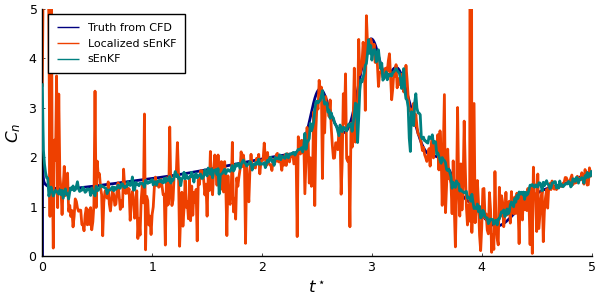

In [29]:
# Generate normal force response
f_enkf = regen_forces(T, map(Xi->vcat(mean(Xi; dims = 2), config.tesp), Xa), config)[1:end-1];
f_loc = regen_forces(T, map(Xi->vcat(mean(Xi; dims = 2), config.tesp), Xa_loc), config)[1:end-1];


plt = plot(ylabel="\$C_n\$", xlabel = L"t^\star", size = (600, 300),
           xlim = (0,tf), ylim = (0, 5))
plot!(plt, thist, 2Fn, label = "Truth from CFD",
     linewidth = 2, legend = :topleft, color = ccfd)

# Result for the localized sEnKF
plot!(plt, T, 2abs.(f_loc), label = "Localized sEnKF", linewidth = 2, color = clocenkf)

# Result for the sEnKF
plot!(plt, T, 2abs.(f_enkf), label = "sEnKF", linewidth = 2, color = cenkf)

In [31]:
@time covf = map(Xi -> cov(Xi; dims = 2), Xf[2:end]);
@time cova = map(Xi -> cov(Xi; dims = 2), Xa[2:end]);

  0.284158 seconds (521.01 k allocations: 72.991 MiB, 89.60% compilation time)
  0.080064 seconds (77.05 k allocations: 47.504 MiB, 54.02% compilation time)


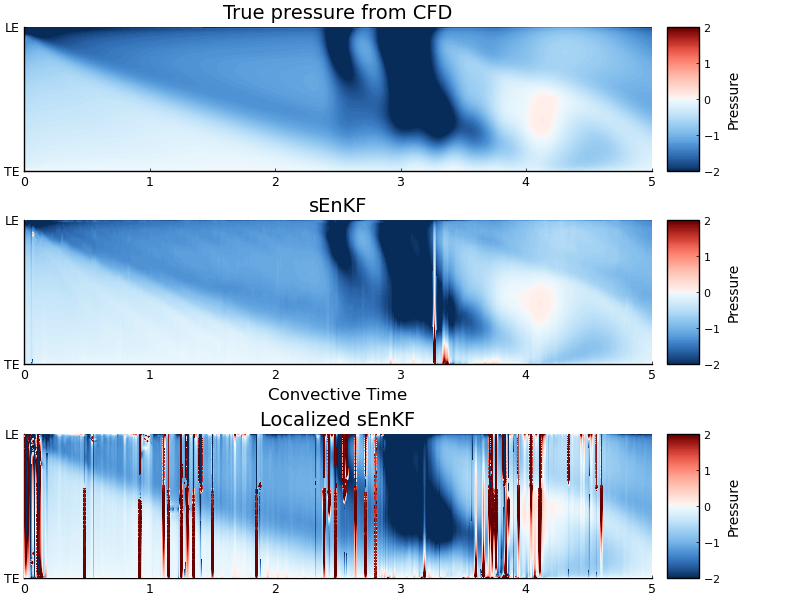

In [69]:
# Spatiotemporal pressure maps
let s = [-0.5config.L*cos(θ) for θ in range(0.0, stop = π, length = config.N)][pressure_taps],
    senkf_pressures = hcat((measure_state(vcat(mean(Xa[i+1]; dims = 2),config.tesp), t, config, pressure_taps) for (i,t) in enumerate(T))...),
    loc_pressures = hcat((measure_state(vcat(mean(Xa_loc[i+1]; dims = 2),config.tesp), t, config, pressure_taps) for (i,t) in enumerate(T))...),
    cfd_pressures = hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)

    plt = plot(layout = (3,1), size = (800, 600))
    contourf!(T, s, [cfd_pressures, senkf_pressures, loc_pressures], 
        title = ["True pressure from CFD" "sEnKF" "Localized sEnKF"],
        levels = range(-2.0, stop  = 2.0, length = 151), clims = (-2, 2), color = cgrad(reverse(colormap("RdBu"))), xlabel = ["" "Convective Time"],
        yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap("RdBu")[end], colorbar_title="Pressure")
end

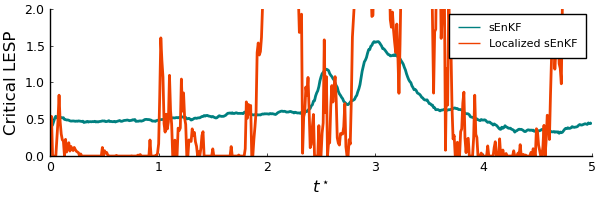

In [46]:
# Plot history of the LESPc estimate 
plt = plot(xlabel = L"t^\star", ylabel = "Critical LESP", size = (600, 200),
           xlim = (0, Inf), ylim = (0, 2.0))

plot!(plt, T, map(Xi ->mean(Xi; dims = 2)[end], Xa)[1:end-1], color = cenkf, 
      label = "sEnKF", linewidth = 2)
plot!(plt, T, map(Xi ->mean(Xi; dims = 2)[end], Xa_loc)[1:end-1], color = clocenkf, 
      label = "Localized sEnKF", linewidth = 2)
# savefig("lespc_Ne"*string(Ne)*".pdf")

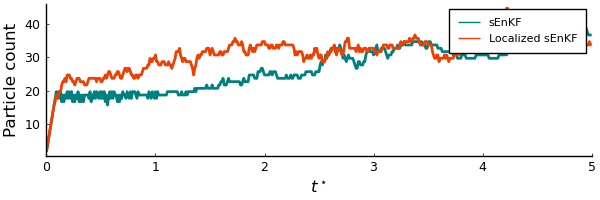

In [59]:
# Plot history of the vortex population 
plt = plot(size = (600, 200), xlim = (0, Inf), xlabel = L"t^\star", ylabel = "Particle count")
plot!(plt, T,  map(Xi ->(length(member(Xi,1))-2)/3, Xa[2:end]), linewidth = 2, 
      color = cenkf, label = "sEnKF")

plot!(plt, T,  map(Xi ->(length(member(Xi,1))-2)/3, Xa_loc[2:end]), linewidth = 2, 
      color = clocenkf, label = "Localized sEnKF")

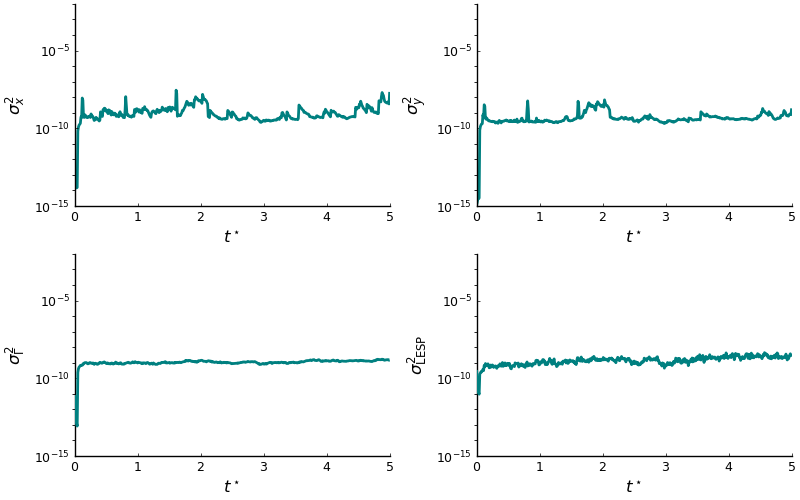

In [67]:
plt = plot(layout = (2,2), size = (800, 500), legend = false, xlims = (0, Inf), xlabel = L"t^\star")
plot!(plt[1], T, map(cova) do P
        mean(diag(P)[1:3:end-1]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2,
        ylabel = "\$\\sigma_x^2\$", color = cenkf)
plot!(plt[2], T, map(cova) do P
        mean(diag(P)[2:3:end-1]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2,
        ylabel = "\$\\sigma_y^2\$", color = cenkf)
plot!(plt[3],T,  map(cova) do P
        mean(diag(P)[3:3:end-1]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2,
        ylabel = "\$\\sigma_\\Gamma^2\$", color = cenkf)
plot!(plt[4], T, map(cova) do P
        mean(diag(P)[end]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2,
        ylabel = "\$\\sigma_\\mathrm{LESP}^2\$", color = cenkf)

Create movies of the flow field from the sEnKF and the localized sEnKF

In [71]:
# Utility routine
function translation!(b, d::ComplexF64)
    for (i, bi) in enumerate(b)
        b[i] = Vortex.Blob(bi.z+d, bi.S, bi.δ)
    end
    return b
end

translation! (generic function with 1 method)

Flow field estimated from the sEnKF and the localized sEnKF

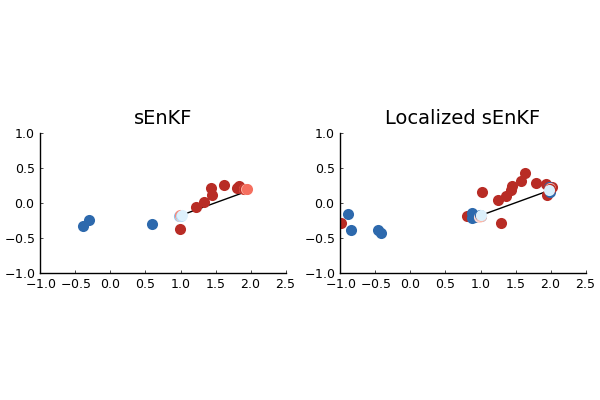

In [98]:
tsnap = 1.5
nsnap = ceil(Int64, tsnap/config.Δt)+1 

# Vorticity estimate from sEnKF
plt1 = plot(ratio = 1.0, legend = false, 
           xlim = (-1,tsnap+1.0), xticks = -1:0.5:tsnap+1.0,
           ylim = (-1.0, 1.0), yticks = -1:0.5:1.0, title = "sEnKF")
plot!(plt1, Plate(config.N, config.L, complex(tsnap), config.α))
plot!(plt1, state_to_blobs(vcat(mean(Xa[nsnap]; dims = 2), 0.0), config.δ)[1], legend = false,
    markersize = 8, markerstrokealpha = 0, color = cgrad(reverse(colormap("RdBu")[10:end-10])), clim = (-0.02, 0.02), 
    ratio = 1)


# Vorticity estimate from sEnKF
plt2 = plot(ratio = 1.0, legend = false, 
           xlim = (-1,tsnap+1.0), xticks = -1:0.5:tsnap+1.0,
           ylim = (-1.0, 1.0), yticks = -1:0.5:1.0, title = "Localized sEnKF")
plot!(plt2, Plate(config.N, config.L, complex(tsnap), config.α))
plot!(plt2, state_to_blobs(vcat(mean(Xa_loc[nsnap]; dims = 2), 0.0), config.δ)[1], legend = false,
    markersize = 8, markerstrokealpha = 0, color = cgrad(reverse(colormap("RdBu")[10:end-10])), clim = (-0.02, 0.02), 
    ratio = 1)

plot(plt1, plt2)

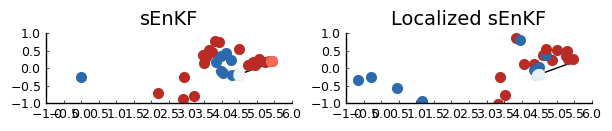

Animation("/var/folders/9m/ffyd2_lx5977_tmsgkjfm66w0000gp/T/jl_akfTIh", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000092.png", "000093.png", "000094.png", "000095.png", "000096.png", "000097.png", "000098.png", "000099.png", "000100.png", "000101.png"])

In [99]:
# Create animation for the sEnKF and the localized sEnKF
anim = @animate for tsnap  in 0.0:0.05:5.0
    nsnap = ceil(Int64, tsnap/config.Δt)+1;

    # Vorticity estimate from sEnKF
    plt1 = plot(ratio = 1.0, legend = false, 
               xlim = (-1,tsnap+1.0), xticks = -1:0.5:tsnap+1.0,
               ylim = (-1.0, 1.0), yticks = -1:0.5:1.0, title = "sEnKF")
    plot!(plt1, Plate(config.N, config.L, complex(tsnap), config.α))
    plot!(plt1, state_to_blobs(vcat(mean(Xa[nsnap]; dims = 2), 0.0), config.δ)[1], legend = false,
        markersize = 8, markerstrokealpha = 0, color = cgrad(reverse(colormap("RdBu")[10:end-10])), clim = (-0.02, 0.02), 
        ratio = 1)


    # Vorticity estimate from sEnKF
    plt2 = plot(ratio = 1.0, legend = false, 
               xlim = (-1,tsnap+1.0), xticks = -1:0.5:tsnap+1.0,
               ylim = (-1.0, 1.0), yticks = -1:0.5:1.0, title = "Localized sEnKF")
    plot!(plt2, Plate(config.N, config.L, complex(tsnap), config.α))
    plot!(plt2, state_to_blobs(vcat(mean(Xa_loc[nsnap]; dims = 2), 0.0), config.δ)[1], legend = false,
        markersize = 8, markerstrokealpha = 0, color = cgrad(reverse(colormap("RdBu")[10:end-10])), clim = (-0.02, 0.02), 
        ratio = 1)

    plot(plt1, plt2)
end

┌ Info: Saved animation to 
│   fn = /Users/mathieu/Documents/LocalizedVortex.jl/notebooks/enkf_50sensors.gif
└ @ Plots /Users/mathieu/.julia/packages/Plots/SkUg1/src/animation.jl:126


Plots.AnimatedGif("/Users/mathieu/Documents/LocalizedVortex.jl/notebooks/enkf_50sensors.gif")
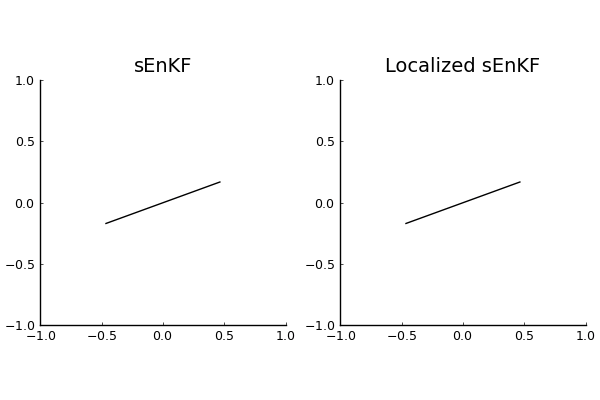

In [100]:
gif(anim, "/Users/mathieu/Documents/LocalizedVortex.jl/notebooks/enkf_50sensors.gif", fps = 5)